### Effective Key Transition : Analysis 2

- key position adjusted in increments of 0.25 mm
- vernier scale and infrared sensor used for key increment calibration
- oscilloscope voltage measurement used for pressure calibration
- key manipulated by mechanical device with **point impact** finger

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import audacity
import TransferFunctions as tf
import SoundUtils as sut
import scipy.signal as sig
import peakutils

%matplotlib notebook

In [2]:
# rpm = 4250
acquisitions = ['3001', '3101']
runs = 15

dfiles4250 = []
for acqno, acq in enumerate(acquisitions):
    dfiles4250.append([])
    for r in range(runs):
        acqfiles = "DATA/microclose/%drpm/%s_closing_%d.aup" % (4250, acq, r)
        dfiles4250[acqno].append(acqfiles)
        
dfiles4500 = []
for acqno, acq in enumerate(acquisitions):
    dfiles4500.append([])
    for r in range(runs):
        acqfiles = "DATA/microclose/%drpm/%s_closing_%d.aup" % (4500, acq, r)
        dfiles4500[acqno].append(acqfiles)
        
dfiles4750 = []
for acqno, acq in enumerate(acquisitions):
    dfiles4750.append([])
    for r in range(runs):
        acqfiles = "DATA/microclose/%drpm/%s_closing_%d.aup" % (4750, acq, r)
        dfiles4750[acqno].append(acqfiles)
        
# reffile = "DATA/microclose/%drpm/2tieclip_reference_sines.aup"

In [3]:
gamma=1.4
P_a=101000
rho_a=1.22
c = 343

chimney=0.0139
bore=0.0186
foot=0.16

# V=(np.pi*bore**2/4)*foot
# const = c**2/(4*np.pi**2*V)

In [4]:
def effective_transition2(aupfile, freqIR, nfft, ch_labium=0, ch_int=1, ch_IR=2, ch_ext=3):
    '''
    Main routine for Effective Key Transition analysis 2.
    Uses spectrum analysis to determine when
    effective key state changes from open to closed.
    
    Input
    -----
    aupfile : audacity project file
    ch_labium, ch_int, ch_IR, ch_ext : (optional) channel numbers
        for labium mic, infrared signal, internal mic and external mic tracks
    IRfreq : frequency of infrared signal modulation
    nfft : window length for transfer function calculation
    
    Output
    ------
    returns a dictionary of the data with the following keys:
    'tf' = transfer function (internal/external response)
    'coh' = coherence (internal vs external)
    'int_mic' = internal response
    'ext_mic' = external responce
    '''    
    auf = audacity.Aup(aupfile)
    print(aupfile)
    sr = auf.rate
    rawdata = []
    maxlen = 0
    for chno in range(auf.nchannels):
        rawdata.append(auf.get_channel_data(chno))
        maxlen = max(maxlen, len(rawdata[-1]))

    data = np.zeros((len(rawdata), maxlen))
    for chno, chdata in enumerate(rawdata):
        data[chno,:len(chdata)] = chdata
        
    lab_ = data[ch_labium,:]
    int_ = data[ch_int,:]
    ext_ = data[ch_ext,:]
    IR = data[ch_IR,:]
    
    datadict = {}
    for chname, chdata in zip(['lab_', 'int_', 'ext_'], [lab_, int_, ext_]):
#         ampl_RMS = np.sqrt(np.mean((chdata-np.mean(chdata))**2))
        spectrum = np.fft.rfft(chdata)
#         freqpeaks = peakutils.indexes(spectrum, ...)
#         intensity = np.array([2*np.pi**2*f**2*amplitude**2*rho_a*c for f in freqpeaks])
#         datadict['%samplitude'%chname] = ampl_RMS
#         datadict['%sspectrum'%chname] = spectrum
        power = 20*np.log10(np.abs(spectrum))
        freqs = np.linspace(0, sr/2, len(power))
        datadict['%syspec'%chname] = power
        datadict['%sxspec'%chname] = freqs
    
    datadict['ir_RMS'] = np.sqrt(np.mean((IR-np.mean(IR))**2))
    return datadict

In [5]:
freqIR = 9820
nfft = 1024*2

In [6]:
results4250 = []
for acqno, acqfiles in enumerate(dfiles4250):
    results4250.append([])
    for file in acqfiles:
        filedata = effective_transition2(file, freqIR, nfft)
        results4250[acqno].append(filedata)
        
# results4500 = []
# for acqno, acqfiles in enumerate(dfiles4500):
#     results4500.append([])
#     for file in acqfiles:
#         filedata = effective_transition2(file, freqIR, nfft)
#         results4500[acqno].append(filedata)
        
# results4750 = []
# for acqno, acqfiles in enumerate(dfiles4750):
#     results4750.append([])
#     for file in acqfiles:
#         filedata = effective_transition2(file, freqIR, nfft)
#         results4750[acqno].append(filedata)

DATA/microclose/4250rpm/3001_closing_0.aup
DATA/microclose/4250rpm/3001_closing_1.aup
DATA/microclose/4250rpm/3001_closing_2.aup
DATA/microclose/4250rpm/3001_closing_3.aup
DATA/microclose/4250rpm/3001_closing_4.aup
DATA/microclose/4250rpm/3001_closing_5.aup
DATA/microclose/4250rpm/3001_closing_6.aup
DATA/microclose/4250rpm/3001_closing_7.aup
DATA/microclose/4250rpm/3001_closing_8.aup
DATA/microclose/4250rpm/3001_closing_9.aup
DATA/microclose/4250rpm/3001_closing_10.aup
DATA/microclose/4250rpm/3001_closing_11.aup
DATA/microclose/4250rpm/3001_closing_12.aup
DATA/microclose/4250rpm/3001_closing_13.aup
DATA/microclose/4250rpm/3001_closing_14.aup
DATA/microclose/4250rpm/3101_closing_0.aup
DATA/microclose/4250rpm/3101_closing_1.aup
DATA/microclose/4250rpm/3101_closing_2.aup
DATA/microclose/4250rpm/3101_closing_3.aup
DATA/microclose/4250rpm/3101_closing_4.aup
DATA/microclose/4250rpm/3101_closing_5.aup
DATA/microclose/4250rpm/3101_closing_6.aup
DATA/microclose/4250rpm/3101_closing_7.aup
DATA/m

<IPython.core.display.Javascript object>


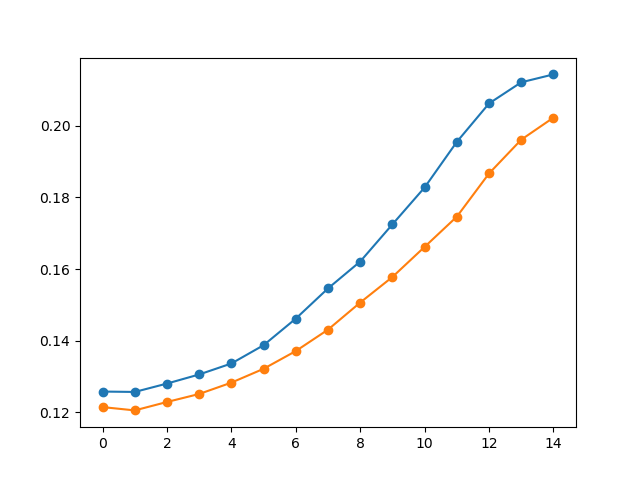

In [7]:
fig = plt.figure()
for acqresults in results4250:
    plt.plot([result['ir_RMS'] for result in acqresults], 'o-')

<IPython.core.display.Javascript object>


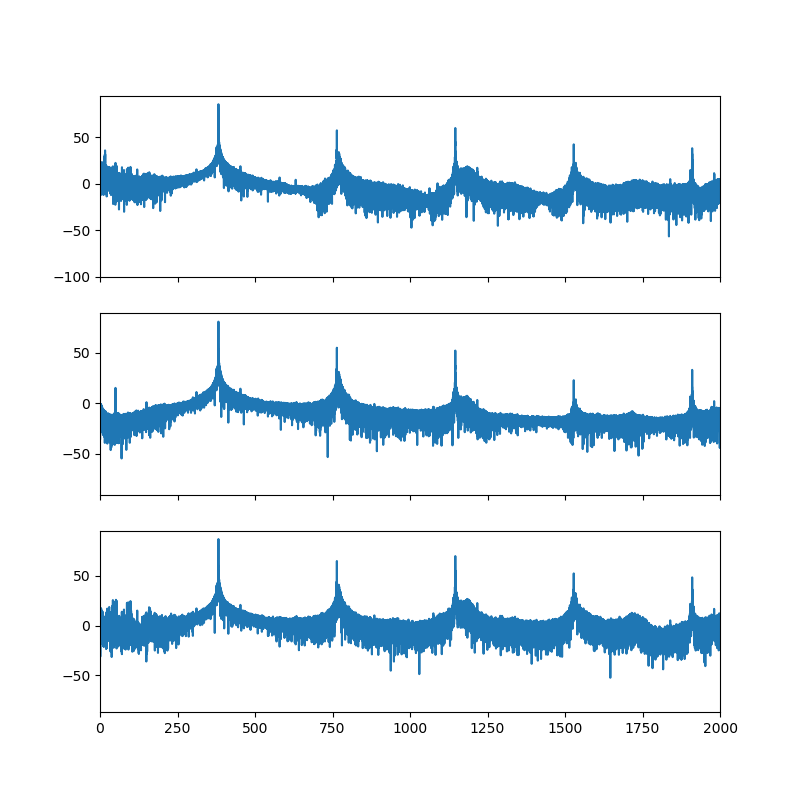

<IPython.core.display.Javascript object>


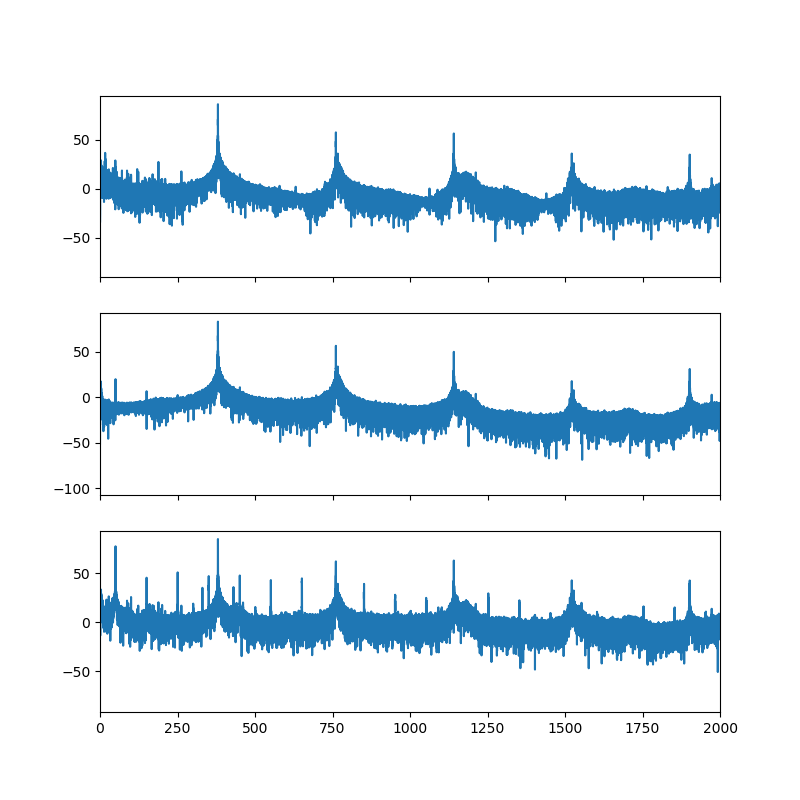

In [47]:
# sr = 44100
for acqresults in results4250:
    fig, ax = plt.subplots(3,sharex=True, figsize=((8,8)))
    ax[0].set_xlim(0, 2000)
    ax[0].plot(acqresults[0]['lab_xspec'], acqresults[0]['lab_yspec'])
    ax[1].plot(acqresults[0]['int_xspec'], acqresults[0]['int_yspec'])
    ax[2].plot(acqresults[0]['ext_xspec'], acqresults[0]['ext_yspec'])

<IPython.core.display.Javascript object>


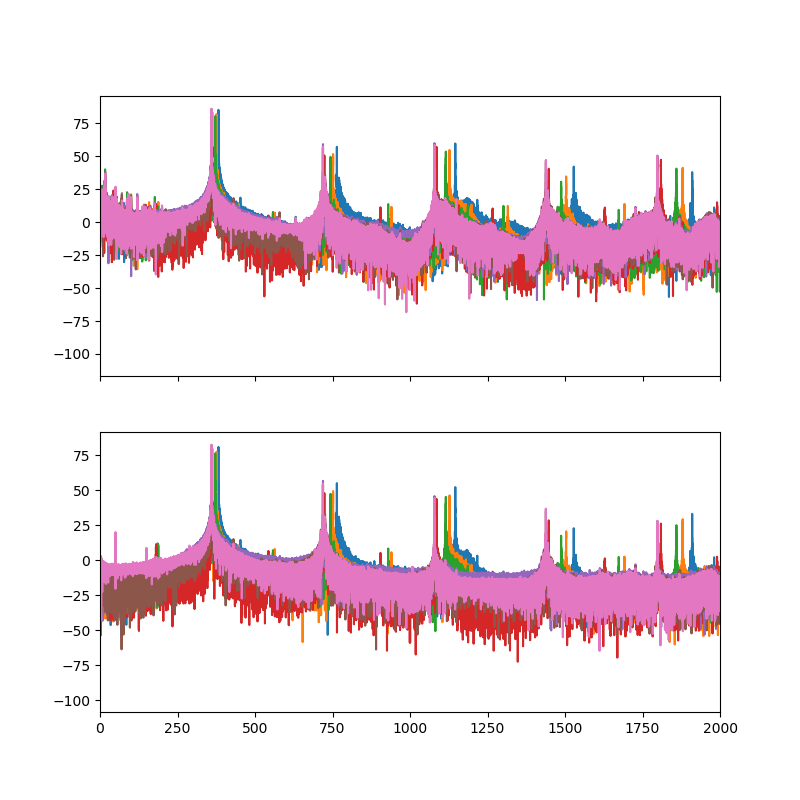

<IPython.core.display.Javascript object>


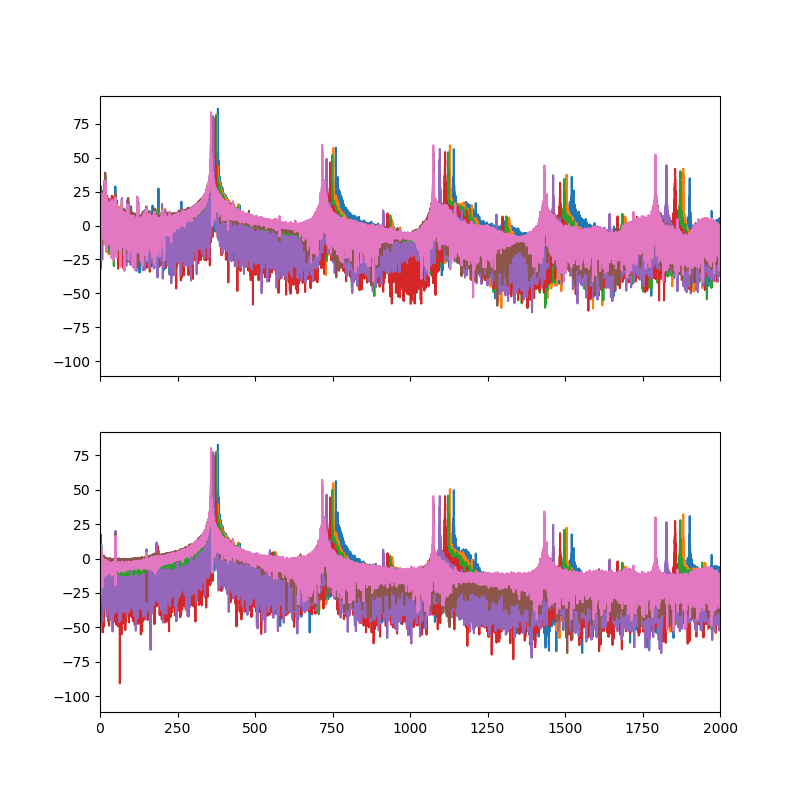

In [76]:
for acqresults in results4250:
    fig,ax = plt.subplots(2,sharex=True, figsize=((8,8)))
#     for r in range(runs):
    for r in [0, 8, 9, 10, 11, 12, 13]:
        ax[0].set_xlim(0, 2000)
        ax[0].plot(acqresults[r]['lab_xspec'], acqresults[r]['lab_yspec'])
        ax[1].plot(acqresults[r]['int_xspec'], acqresults[r]['int_yspec'])
#         ax[2].plot(acqresults[r]['ext_xspec'], acqresults[r]['ext_yspec'])

<IPython.core.display.Javascript object>


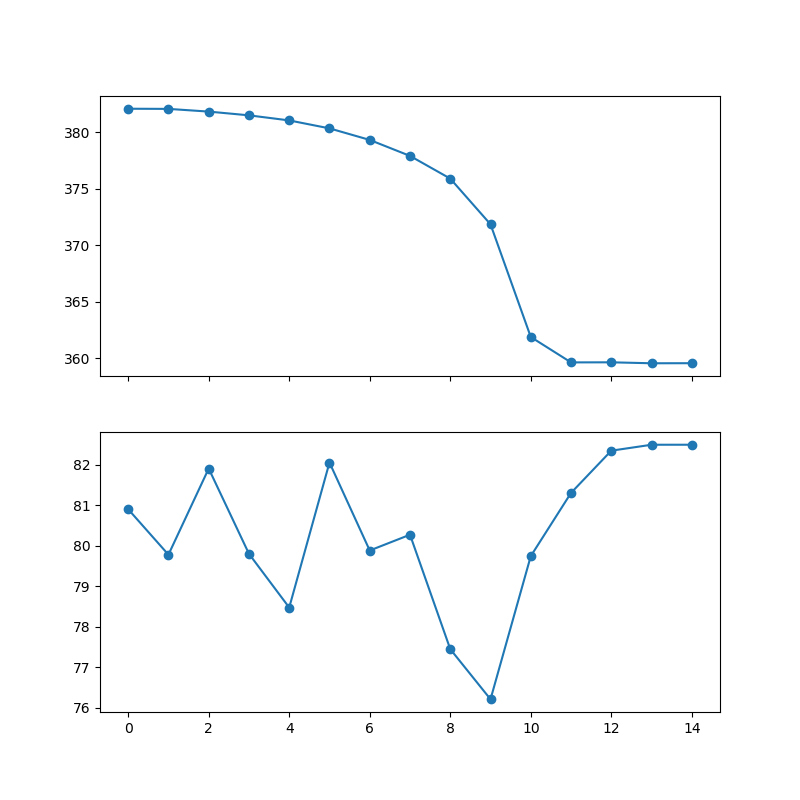

<IPython.core.display.Javascript object>


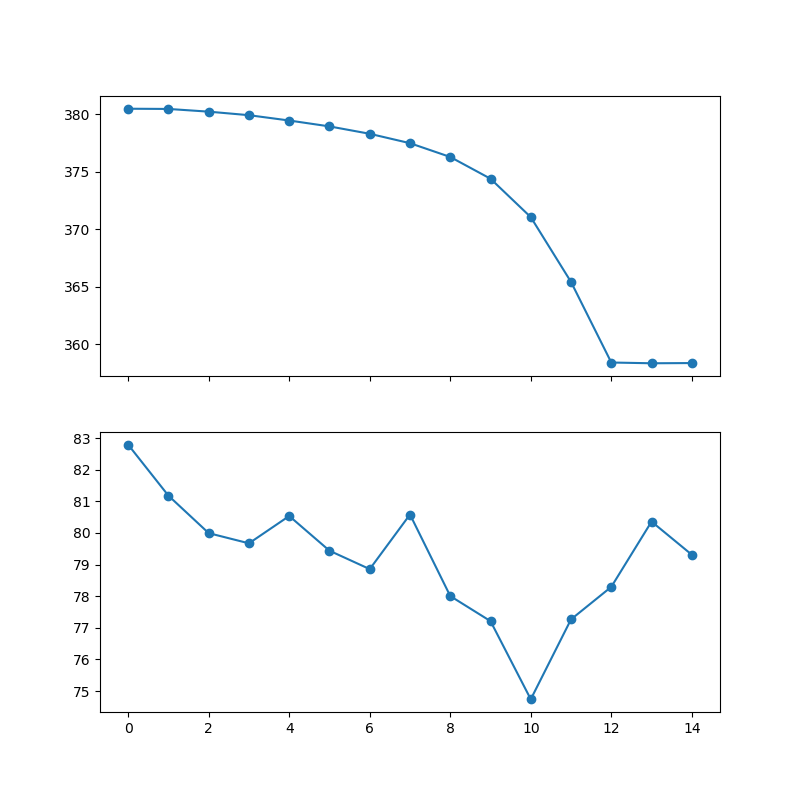

In [17]:
for acqresults in results4250:
    fig,ax = plt.subplots(2, sharex=True, figsize=((8,8)))
    incrs = [i for i in range(runs)]
    DBpeaks = []
    Fpeaks = []
    for r in incrs:
        fpeak = peakutils.indexes(acqresults[r]['int_yspec'], thres=0.9, min_dist=150)
        DBpeaks.extend(acqresults[r]['int_yspec'][fpeak])
        Fpeaks.extend(acqresults[r]['int_xspec'][fpeak])
    
    ax[0].plot(incrs, Fpeaks, 'o-')
    ax[0].set_label('Frequency vs closing')
    ax[1].plot(incrs, DBpeaks, 'o-')
    ax[1].set_label('dB vs closing')
#     plt.legend(loc='best', ncol=3)